# Advanced ML - Exercise 4 Notebook
By:<br>
ID: 346243579<br>
ID: 203909320


## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/IDC_AdvML

/content/gdrive/.shortcut-targets-by-id/1Fg_Qoe86_zPHEpJP7qQTjfY7jrnT010g/IDC_AdvML


In [ ]:
import pandas as pd
import numpy as np
import shutil
import os
import json
import pickle
from tqdm import tqdm
tqdm.pandas()
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score as silscore
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
import torch
import spacy
import gensim
import gzip
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
!pip install --quiet sentence-transformers

     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 4.2 MB 17.9 MB/s 
     |████████████████████████████████| 1.2 MB 50.4 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 6.6 MB 63.9 MB/s 
     |████████████████████████████████| 596 kB 79.5 MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer,util # we need util.cos_sim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model_specter = SentenceTransformer('allenai-specter')

Using device: cuda


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/622 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

# Data preprocessing

This section is dedicated to extract, clean and build the initial dataset of papers used for the project.

In [ ]:
! cd /content/drive/MyDrive/IDCJoel/kaggle_dataset
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/IDCJoel/kaggle_dataset/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

In [ ]:
! unzip /content/drive/MyDrive/IDCJoel/kaggle_dataset/CORD-19-research-challenge.zip -d /content/drive/MyDrive/IDCJoel/kaggle_dataset

In [ ]:
base_path = "/Users/joelliurner/Desktop/cord_dataset"
extracted_path = "/Users/joelliurner/Desktop/cord_dataset/extracted"
json_schema_path = base_path+"/json_schema.txt"
metadata_path = base_path+"/metadata.csv"

In [ ]:
!cat {json_schema_path}

# JSON schema of full text documents


{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 1

In [ ]:
df_metadata = pd.read_csv(metadata_path)

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
df_metadata.sort_values('publish_time', ascending=False, inplace=True)

In [ ]:
#There is one article of 2024, and several in december 2022, ignore them
df_metadata = df_metadata[df_metadata['publish_time'] < '2022-03-26']

In [ ]:
# Drop inconsistent samples
df_metadata.dropna(subset=['sha'], inplace=True)
df_metadata.dropna(subset=['abstract'], inplace=True)
df_metadata.dropna(subset=["pdf_json_files"], inplace=True)
df_metadata.dropna(subset=["pmc_json_files"], inplace=True)
df_metadata.reset_index(inplace = True)

In [ ]:
# Keep useful articles, with text and abstract
# Extract 20k recent samples
df_sample20 = df_metadata[0:20000].copy()
#df_sample20 = df_metadata[0:20].copy()
df_sample20['text'] = None
for i in range(len(df_sample20)):
#for i in range(5):
    file_path = df_sample20.loc[i]['pmc_json_files']
    new_file_path = os.path.join(extracted_path,file_path)
    shutil.copyfile( os.path.join(base_path,file_path), new_file_path )
    with open(new_file_path) as file:
        content = json.load(file)
        text = []
        for entry in content['body_text']:
            text.append(entry['text'])
  
        text = '\n'.join(text)
    df_sample20.at[i, 'text']= text

In [ ]:
del df_metadata
df_sample20.head()

,index,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,text
0,884121,flrlee96,c86d5946ce78b0c8fc0e43fb1a33c1a5ee3feeef; c0e2...,Elsevier; PMC,Assessing face masks in the environment by mea...,10.1016/j.scitotenv.2021.152859,PMC8724021,34995587.0,no-cc,The use of face masks outside the health care ...,...,"Tesfaldet, Yacob T.; Ndeh, Nji T.",Sci Total Environ,NaN,NaN,NaN,document_parses/pdf_json/c86d5946ce78b0c8fc0e4...,document_parses/pmc_json/PMC8724021.xml.json,https://api.elsevier.com/content/article/pii/S...,245652163.0,"As the name implies, single-use face masks are..."
1,888988,g7ddk1hm,819e829dbefd87a2eaf166bca8dfdf8476aed245,Elsevier; Medline; PMC; WHO,Pharmaceutical compounds used in the COVID-19 ...,10.1016/j.scitotenv.2021.152691,PMC8717703,34974020.0,no-cc,"During the COVID-19 pandemic, high consumption...",...,"Morales-Paredes, Carlos Augusto; Rodríguez-Día...",Sci Total Environ,NaN,NaN,NaN,document_parses/pdf_json/819e829dbefd87a2eaf16...,document_parses/pmc_json/PMC8717703.xml.json,https://www.sciencedirect.com/science/article/...,245568730.0,The presence of pharmaceutical compounds and t...
2,812118,pb66cb6k,1840b4d970cd26945d9d11c26fa043f44aa26c19; ce63...,Elsevier; Medline; PMC; WHO,Health consequences of disinfection against SA...,10.1016/j.scitotenv.2021.152832,PMC8720300,34986424.0,no-cc,Individuals who get involved in the disinfecti...,...,"Rafiee, Ata; Delgado-Saborit, Juana Maria; Sly...",Sci Total Environ,NaN,NaN,NaN,document_parses/pdf_json/1840b4d970cd26945d9d1...,document_parses/pmc_json/PMC8720300.xml.json,https://api.elsevier.com/content/article/pii/S...,245617000.0,"COVID-19, a disease caused by the severe acute..."
3,837564,orkeretn,0e377eaf4bc70ad866a446fa36c6d4bbd52f7bb5; 460d...,Elsevier; Medline; PMC; WHO,"Brief, parent-led, transdiagnostic cognitive-b...",10.1016/j.jad.2022.01.034,PMC8752168,35031335.0,no-cc,BACKGROUND: The COVID-19 pandemic has led to i...,...,"Guzick, Andrew G.; Leong, Alicia W.; Dickinson...",J Affect Disord,NaN,NaN,NaN,document_parses/pdf_json/0e377eaf4bc70ad866a44...,document_parses/pmc_json/PMC8752168.xml.json,https://doi.org/10.1016/j.jad.2022.01.034; htt...,245855662.0,The COVID-19 pandemic has changed nearly every...
4,807972,sd6pg3sf,f6b6be81a360f4d90553b62b95f5e15201df5ac9; 3c85...,Elsevier; Medline; PMC; WHO,Direct capture and smartphone quantification o...,10.1016/j.bios.2021.113912,PMC8701770,34973565.0,no-cc,"SARS, a new type of respiratory disease caused...",...,"Kim, Sangsik; Akarapipad, Patarajarin; Nguyen,...",Biosens Bioelectron,NaN,NaN,NaN,document_parses/pdf_json/f6b6be81a360f4d90553b...,document_parses/pmc_json/PMC8701770.xml.json,https://api.elsevier.com/content/article/pii/S...,245426397.0,We have recently witnessed the worldwide pande...


In [ ]:
df_sample20.drop(['source_x', 'doi', 'pmcid', 'pubmed_id', 'license', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'url', 's2_id'], axis=1)

,index,cord_uid,sha,title,abstract,publish_time,pdf_json_files,pmc_json_files,text
0,884121,flrlee96,c86d5946ce78b0c8fc0e43fb1a33c1a5ee3feeef; c0e2...,Assessing face masks in the environment by mea...,The use of face masks outside the health care ...,2022-03-25,document_parses/pdf_json/c86d5946ce78b0c8fc0e4...,document_parses/pmc_json/PMC8724021.xml.json,"As the name implies, single-use face masks are..."
1,888988,g7ddk1hm,819e829dbefd87a2eaf166bca8dfdf8476aed245,Pharmaceutical compounds used in the COVID-19 ...,"During the COVID-19 pandemic, high consumption...",2022-03-25,document_parses/pdf_json/819e829dbefd87a2eaf16...,document_parses/pmc_json/PMC8717703.xml.json,The presence of pharmaceutical compounds and t...
2,812118,pb66cb6k,1840b4d970cd26945d9d11c26fa043f44aa26c19; ce63...,Health consequences of disinfection against SA...,Individuals who get involved in the disinfecti...,2022-03-25,document_parses/pdf_json/1840b4d970cd26945d9d1...,document_parses/pmc_json/PMC8720300.xml.json,"COVID-19, a disease caused by the severe acute..."
3,837564,orkeretn,0e377eaf4bc70ad866a446fa36c6d4bbd52f7bb5; 460d...,"Brief, parent-led, transdiagnostic cognitive-b...",BACKGROUND: The COVID-19 pandemic has led to i...,2022-03-15,document_parses/pdf_json/0e377eaf4bc70ad866a44...,document_parses/pmc_json/PMC8752168.xml.json,The COVID-19 pandemic has changed nearly every...
4,807972,sd6pg3sf,f6b6be81a360f4d90553b62b95f5e15201df5ac9; 3c85...,Direct capture and smartphone quantification o...,"SARS, a new type of respiratory disease caused...",2022-03-15,document_parses/pdf_json/f6b6be81a360f4d90553b...,document_parses/pmc_json/PMC8701770.xml.json,We have recently witnessed the worldwide pande...
...,...,...,...,...,...,...,...,...,...
19995,770507,1syhlbxn,3d3cb448ed070224af8f6940cab1eea6dac69cc6,The European Genome-phenome Archive in 2021,The European Genome-phenome Archive (EGA - htt...,2021-11-17,document_parses/pdf_json/3d3cb448ed070224af8f6...,document_parses/pmc_json/PMC8728218.xml.json,The European Genome-phenome Archive (EGA) is a...
19996,770638,wxkivq3b,53cb2c64647a2136998a5f8955d73d7bbb8bff5b,Adverse drug reactions reporting practice and ...,INTRODUCTION: timely adverse drug reactions (A...,2021-11-17,document_parses/pdf_json/53cb2c64647a2136998a5...,document_parses/pmc_json/PMC8683451.xml.json,Adverse Drug Reactions (ADRs) constitute an im...
19997,852900,a8euut84,034d787fdafaa888e699da8f69be56ad8c651579,Role of miRNAs as biomarkers of COVID-19: a sc...,Aim: miRNAs are potential biomarkers of severa...,2021-11-17,document_parses/pdf_json/034d787fdafaa888e699d...,document_parses/pmc_json/PMC8601154.xml.json,A comprehensive search of literature published...
19998,819775,omrgr0r7,8d6ece323f61d6657e70e7994701bbd9d889e584,Access to material resources and the subjectiv...,This article analyzes the relationships betwee...,2021-11-17,document_parses/pdf_json/8d6ece323f61d6657e70e...,document_parses/pmc_json/PMC8596856.xml.json,Notable importance in recent years has been as...


In [ ]:
# Save to Pickle to use this data as base for the model
df_sample20.to_pickle('df_sample20.pickle')

# Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/IDC_AdvML

/content/gdrive/.shortcut-targets-by-id/1Fg_Qoe86_zPHEpJP7qQTjfY7jrnT010g/IDC_AdvML


In [ ]:
df = pd.read_pickle('df_sample20.pickle')

In [ ]:
df[['sha', 'title', 'abstract','journal','text']].head(3)

,sha,title,abstract,journal,text
0,c86d5946ce78b0c8fc0e43fb1a33c1a5ee3feeef; c0e2...,Assessing face masks in the environment by mea...,The use of face masks outside the health care ...,Sci Total Environ,"As the name implies, single-use face masks are..."
1,819e829dbefd87a2eaf166bca8dfdf8476aed245,Pharmaceutical compounds used in the COVID-19 ...,"During the COVID-19 pandemic, high consumption...",Sci Total Environ,The presence of pharmaceutical compounds and t...
2,1840b4d970cd26945d9d11c26fa043f44aa26c19; ce63...,Health consequences of disinfection against SA...,Individuals who get involved in the disinfecti...,Sci Total Environ,"COVID-19, a disease caused by the severe acute..."


AttributeError: ignored

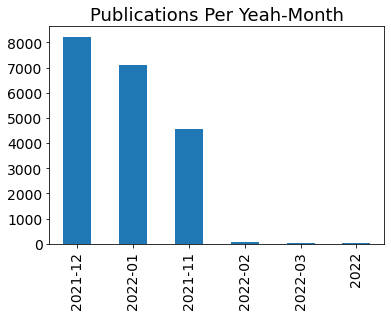

In [ ]:
ax = df['publish_time'].apply(lambda x:x[0:-3] if len(x) > 4 else x).value_counts().plot(kind = 'bar', fontsize =14, title = 'Publications Per Yeah-Month')
ax.title.set_size(18)
ax.bar_label(ax.containers[0],fontsize=14)
plt.xticks(rotation=70)
plt.show()

AttributeError: ignored

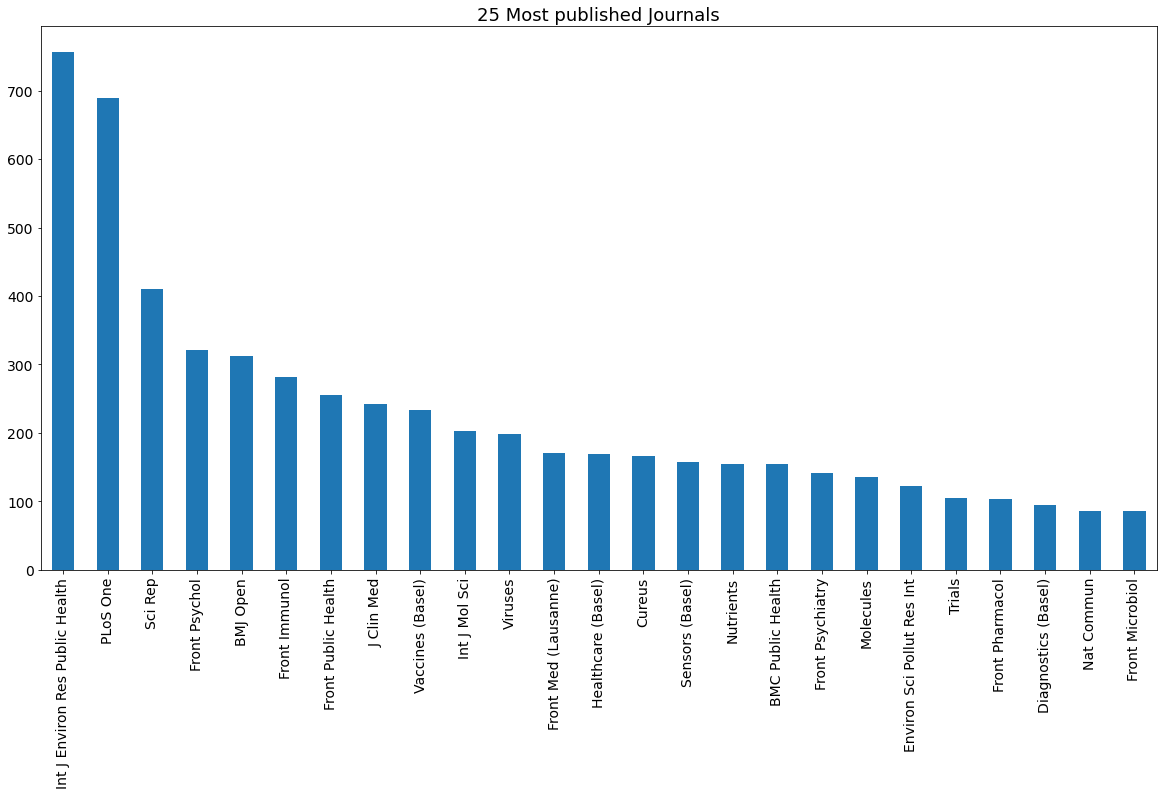

In [ ]:
ax = df['journal'].value_counts().nlargest(25).plot(kind = 'bar', fontsize =14,figsize = (20,10), title = '25 Most published Journals')
ax.title.set_size(18)
ax.bar_label(ax.containers[0],fontsize=14)
plt.xticks(rotation=70)
plt.show()

AttributeError: ignored

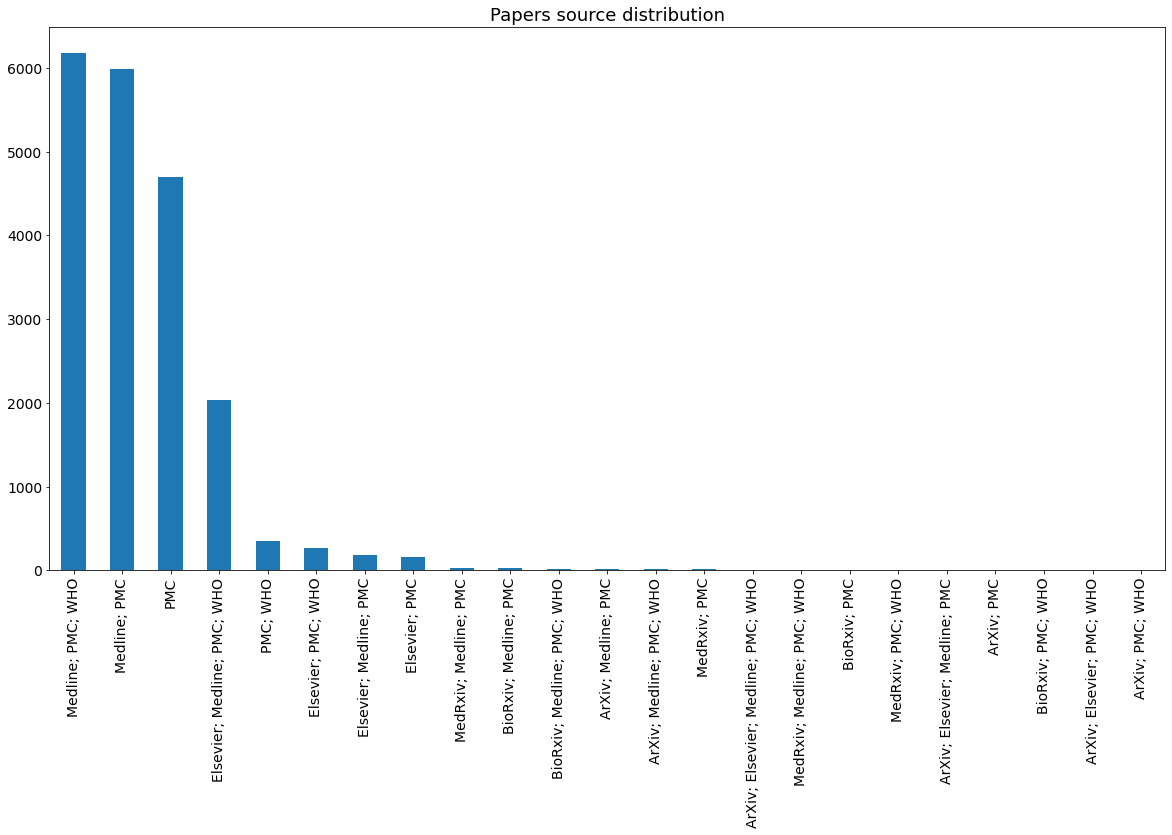

In [ ]:
ax = df['source_x'].value_counts().plot(kind = 'bar', fontsize =14,figsize = (20,10), title = 'Papers source distribution')
ax.title.set_size(18)
plt.xticks(rotation=70)
plt.show()

# Part 1

## Embedding and similarity - Transformers model

In this part of the assignment we will use [SPECTER](https://arxiv.org/abs/2004.07180) which is Document-level Representation Learning using Citation-informed Transformers. from prior experience in the field we know that it is a robust transformers model which is fitted for the exact task of dealing with scientific documents.
it is cable of getting an article's abstract as an input sequence, but is limited up to 512 tokens.<br>
We will use Cosine Similarity as a measure of similarity

In [ ]:
df_sample20 = pd.read_pickle('df_sample20.pickle')['abstract']
df = pd.read_pickle('df_sample20.pickle')[['title','abstract','text']]
df_sample20.head(3)

0    The use of face masks outside the health care ...
1    During the COVID-19 pandemic, high consumption...
2    Individuals who get involved in the disinfecti...
Name: abstract, dtype: object

In [ ]:
df['title'].apply(len)

0         71
1        138
2        120
3        134
4         96
        ... 
19995     43
19996    153
19997    121
19998     90
19999     72
Name: title, Length: 20000, dtype: int64

**Input Sequence Length:**<br>
For Transformer models like BERT / RoBERTa / DistilBERT etc. the runtime and the memory requirement grows quadratic with the input length. This limits transformers to inputs of certain lengths. A common value for BERT & Co. are 512 word pieces, which corresponde to about 300-400 words (for English). Longer texts than this are truncated to the first x word pieces.

By default, the provided methods use a limit fo 128 word pieces, longer inputs will be truncated. You can get and set the maximal sequence length like this:

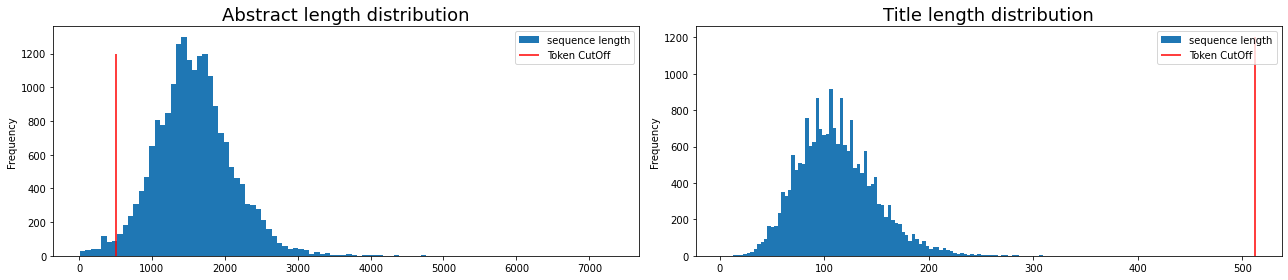

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8, 8))
# df.groupby(df["date"].dt.year)['id'].count().plot(kind="bar",ax=ax[0],title='Distribution of years')
df_sample20.apply(len).plot(kind='hist',bins=100,figsize = (18,4),ax=ax[0],label='sequence length', title = 'Abstract length distribution')
ax[0].vlines(x=512, ymin=0, ymax=1200, colors='r',label='Token CutOff')
ax[0].title.set_size(18)
df['title'].apply(len).plot(kind='hist',bins=100,figsize = (18,4),ax=ax[1],label='sequence length', title = 'Title length distribution')
ax[1].vlines(x=512, ymin=0, ymax=1200, colors='r',label='Token CutOff')
ax[1].title.set_size(18)
fig.tight_layout()
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
model_specter

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
def Papers_Sim(model,x,y):
  '''
  * Similarity metric *
  Getting the Cosine Similarity of two papers (abstracts)
  using SPECTER encoder in order to embedd each paper and then apply Cos - Sim between two representing embedding vectors
  input: 
           x,y - papers
  returns:
           Similarity \in [0,1] where:
              0 - Completely dissimilar
              1 - Identical
  '''
  X = model.encode(x, convert_to_tensor=True,device= device)
  Y = model.encode(y, convert_to_tensor=True,device= device)
  sim = util.cos_sim(X,Y)
  return sim.item()


## LDA

In [ ]:
!pip install pyldavis

In [ ]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
text_list = df.abstract.tolist()

In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(text_list)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(text_list)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:2032: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning,


In [ ]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.170264  0.034046       1        1  11.029060
1     -0.035066  0.222524       2        1   7.594127
3     -0.105017 -0.188997       3        1   7.431937
19    -0.133019 -0.011275       4        1   7.042777
11    -0.041444  0.218178       5        1   6.900718
7     -0.162990 -0.115593       6        1   6.076045
9     -0.172973  0.157550       7        1   5.135943
15    -0.097840 -0.005876       8        1   5.020959
14    -0.006685 -0.160973       9        1   4.965005
2     -0.136733 -0.146356      10        1   4.768732
10     0.179292 -0.034486      11        1   4.759647
4      0.197179 -0.066397      12        1   4.654881
8      0.125390 -0.062357      13        1   3.935210
0      0.168328  0.161246      14        1   3.567818
18    -0.036912  0.099947      15        1   3.555557
5     -0.046972 -0.134699      16        1   3.083017
16     0.199780 -0.012635      17        1   2.712725
17     0.056952  0.035812      18        1   2.688965
13    -0.036407  0.057572      19        1   2.619613
6      0.255400 -0.047228      20        1   2.457265, topic_info=               Term          Freq         Total Category  logprob  loglift
7827       patients  21618.000000  21618.000000  Default  30.0000  30.0000
2503          covid  32299.000000  32299.000000  Default  29.0000  29.0000
2491            cov  11149.000000  11149.000000  Default  28.0000  28.0000
9557           sars  11214.000000  11214.000000  Default  27.0000  27.0000
11428       vaccine   5390.000000   5390.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
11406         using    278.797517   8644.260286  Topic20  -5.3832   0.2720
4052     expression    219.185248   1759.074755  Topic20  -5.6238   1.6235
9306    respiratory    215.263881   3635.525359  Topic20  -5.6419   0.8795
5663   interactions    202.202150    928.371854  Topic20  -5.7044   2.1820
1037          based    204.766241   8274.479342  Topic20  -5.6918   0.0071

[1619 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
5          2  0.105057  abdominal
5          5  0.091354  abdominal
5         18  0.794780  abdominal
22        14  0.987913        abs
23        18  0.982259    abscess
...      ...       ...        ...
11870     11  0.990811       zikv
11872      4  0.022512       zinc
11872      5  0.030015       zinc
11872     12  0.900460       zinc
11872     20  0.037519       zinc

[7736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 2, 4, 20, 12, 8, 10, 16, 15, 3, 11, 5, 9, 1, 19, 6, 17, 18, 14, 7])

## Word2Vec - calculate similarity with a general pretrained Word2Vec model

In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 8.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
spacy_model = spacy.load('en_core_web_sm')

In [ ]:
def Spacy_Papers_Sim(model,x,y):
  # Pre-process with gensim standard util function
  X = gensim.utils.simple_preprocess(x)
  X = ' '.join([token for token in X])
  Y = gensim.utils.simple_preprocess(y)
  Y = ' '.join([token for token in Y])

  # Apply Word2Vec Model
  X = model(X)
  Y = model(Y)
  
  # Vector average
  X = sum(token.vector for token in X) / float(len(X))
  Y = sum(token.vector for token in Y) / float(len(Y))

  # Calculate cosine similarity
  sim = util.cos_sim(X,Y)

  return sim.item()

In [ ]:
Spacy_Papers_Sim(spacy_model, df['abstract'].loc[0], df['abstract'].loc[1] )

0.9590094089508057

#Part 2: Embedding and reducing dimensions of all papers

## Analysis of model

#### Embed the abstracts: (run only once)


In [ ]:
##only run once
# df['embedding'] = df['abstract'].progress_apply(lambda x:  model_specter.encode(x, convert_to_numpy=True,device= device))

100%|██████████| 20000/20000 [08:27<00:00, 39.43it/s]


In [ ]:
## only run once
# embds = np.vstack(df['embedding'].to_numpy())
## Save to Pickle to use this data as base for the model
# with open('embds.pickle','wb') as f: pickle.dump(embds, f)

#### Perform analysis

In [ ]:
with open('embds.pickle','rb') as f: embds = pickle.load(f)
print('Shape of embedding matrix is now:',embds.shape)
embds 

Shape of embedding matrix is now: (20000, 768)


array([[-0.37013575,  0.32406062,  0.24475694, ...,  0.05047796,
        -0.66511184,  0.65118957],
       [ 0.5839754 , -0.07836206,  0.9360734 , ..., -0.9290022 ,
        -0.01539254,  0.27067184],
       [ 0.23704852, -0.04339355,  0.00330326, ..., -0.06369844,
         0.19470336, -0.3056854 ],
       ...,
       [-0.341525  ,  1.3623118 ,  0.25961354, ...,  0.10698318,
         0.40044975, -0.39203623],
       [-0.9238409 ,  0.05564831,  0.95993555, ...,  0.00909325,
         0.2832011 ,  1.1174376 ],
       [ 0.34845114,  0.98101676,  0.13470685, ...,  0.02807596,
        -0.35681877, -0.15972897]], dtype=float32)

Use PCA of 3 principal components to reduce dimensions

In [ ]:
pca = PCA(n_components=3)
abst_pca = pca.fit_transform(embds)

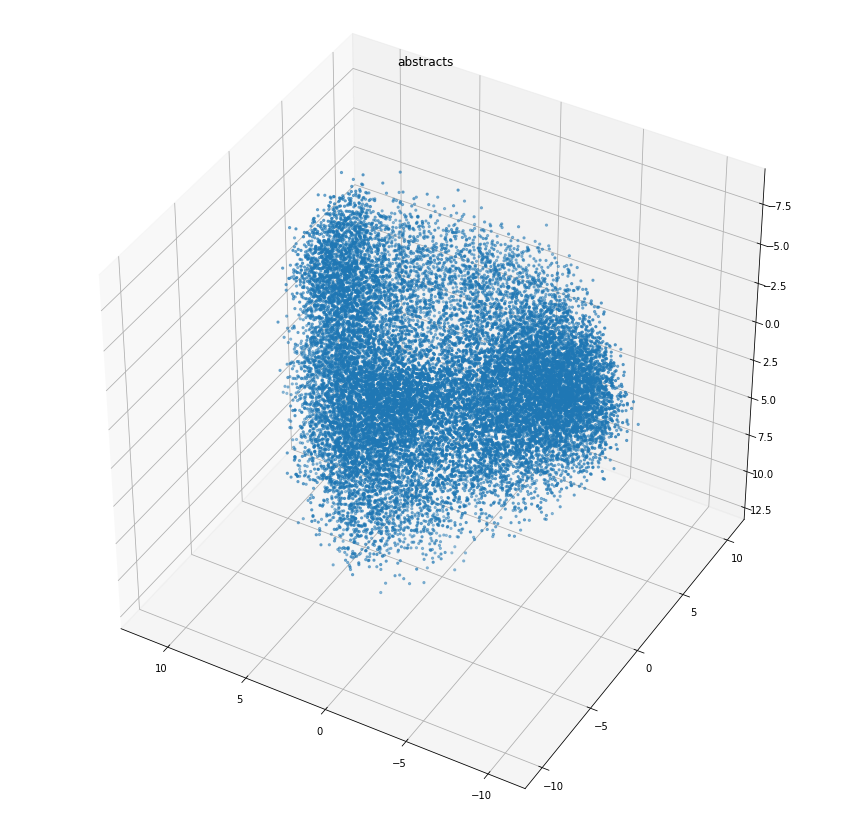

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

ax.scatter(abst_pca[:,0], abst_pca[:,1], abst_pca[:,2],marker='.')
ax.set_title('abstracts')
ax.view_init(-140, 60)
fig.show()

In [ ]:
abst_pca

array([[-2.1087337 ,  3.0243015 , -0.23456328],
       [ 4.718452  ,  0.3630881 , -3.8087223 ],
       [-0.6345664 , -3.3247821 , -0.11936519],
       ...,
       [ 2.7097952 , -1.3388543 , -1.8869073 ],
       [-8.069397  ,  1.1541392 , -2.937495  ],
       [ 5.902197  , -2.8439236 ,  2.7537384 ]], dtype=float32)

In [ ]:
inertia = []
K = 20
sil_score = []
for k in tqdm(range(2,K)):
  kmeans = KMeans(n_clusters=k,max_iter=300,tol=0.001,init='k-means++',random_state=42)
  kmeans.fit(abst_pca)
  inertia.append(kmeans.inertia_)
  sil_score.append(silscore(abst_pca,kmeans.labels_))

100%|██████████| 18/18 [01:30<00:00,  5.04s/it]


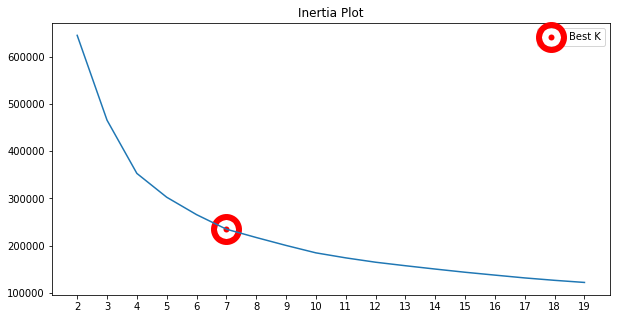

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(2,K,1),inertia,)
plt.xticks(np.arange(2,K,1))
plt.title('Inertia Plot')
plt.scatter(7,inertia[7-2], color = 'r',label ='Best K' , linewidths = 25)
plt.legend()
plt.show()

Now cluster, based on the best k found with elbow-heuristic from above, $k = 7$

In [ ]:
cluster = KMeans(n_clusters=7,max_iter=300,tol=0.001,init='k-means++',random_state=42)
cluster.fit(abst_pca)

KMeans(n_clusters=7, random_state=42, tol=0.001)

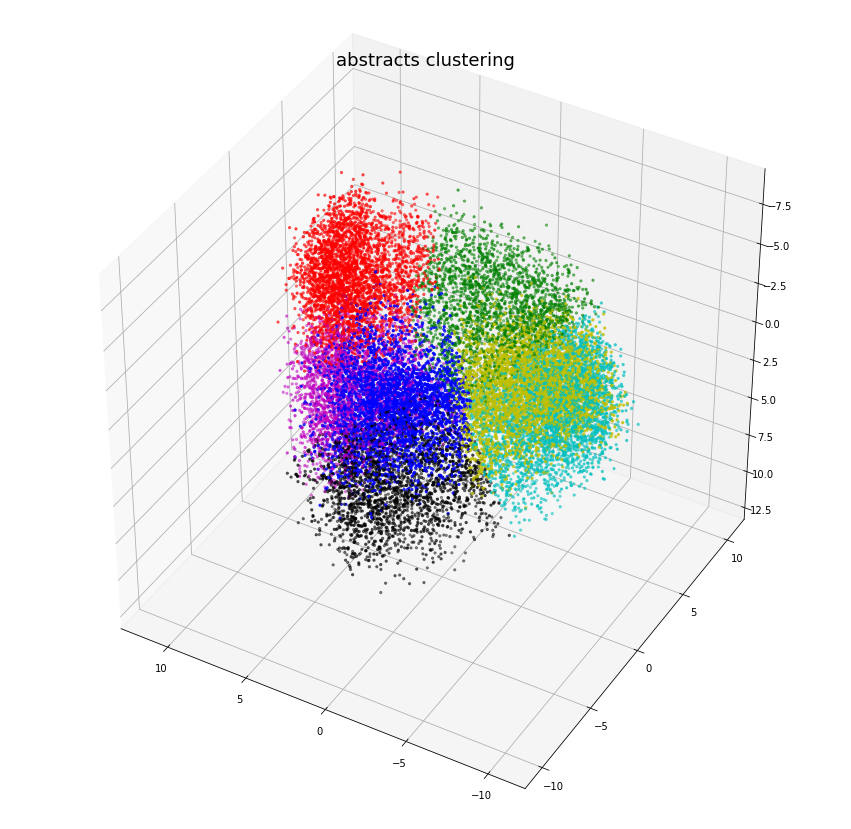

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
d = {0: 'b',
     1: 'g',
     2: 'r',
     3: 'c',
     4: 'm',
     5: 'y',
     6: 'k'}
col = [d[val] for val in cluster.labels_]
ax.scatter(abst_pca[:,0], abst_pca[:,1], abst_pca[:,2],marker='.',c= col)
ax.set_title('abstracts clustering',fontsize = 18)
ax.view_init(-140, 60)
fig.show()

In [ ]:
df['labels']= cluster.labels_

In [ ]:
#Silhouette score
silscore(abst_pca,cluster.labels_)

0.3077396

Perform TFIDF to identify most relevant words per cluster

In [ ]:
def tfidf_words(text,n_top=25,by='title'):

  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words='english')
  tfidf = tfidf_vectorizer.fit_transform(text)

  # sort by importance
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]

  # get words
  tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

  return tfidf_feature_names[importance[:n_top]]

In [ ]:
cluster_words_dict = {}
#common words in all texts, to remove
common_words = ['patients', 'patient', 'covid', 'cov', '19', 'et', 'al', 'sars', 'health', 'used', 'using', 'cell', 'cells','new','care', 'participants', 'study', 'data', 'fig', 'figure', '2020', 'pandemic', 'usepackage','based','95','2019','ci','case','cases']
title_list = []
text_list = []

for label in np.sort(df.labels.unique()):
  text_list = df[df.labels == label].abstract.tolist()
  words = tfidf_words(text_list)

  #remove common words
  for w in common_words:
    if w in words: 
      index = np.argwhere(words==w)
      words = np.delete(words,index)
  cluster_words_dict[label] = words
  text_list = []

In [ ]:
for k in cluster_words_dict.keys():
  print('Cluster ',k, 'frequent words: \n', cluster_words_dict[k])
  print('---'*50)

Cluster  0 frequent words: 
 ['results' 'disease' 'high' 'treatment' 'analysis' 'potential' 'model'
 'clinical' 'different' 'review' 'activity' 'protein' 'cancer' 'effects'
 'studies' 'human']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster  1 frequent words: 
 ['vaccine' 'vaccination' 'disease' 'risk' 'model' 'social' 'public'
 'countries' 'results' 'infection' 'measures']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster  2 frequent words: 
 ['infection' 'vaccine' 'virus' 'viral' 'protein' 'disease' 'coronavirus'
 'vaccination' 'immune' 'vaccines' 'variants' 'results' 'human' 'spike'
 'antibody']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster  3 frequent wor

As per the results, we could say that the topics of the documents for each cluster are:
- Cluster 0: related to treatments
- Cluster 1: data on vaccination results
- Cluster 2: technical details on the virus spike protein.
- Cluster 3: related to students researches and results
- Cluster 4: related to high risks, acute infections and mortality
- Cluster 5: seems to be a less technical group, more related to social and online results
- Cluster 6: similart to cluster 4 on acute infections but related found results on studies.

Try kmeans where $k=7$  without pca's reducing dimensions

In [ ]:
clusterall = KMeans(n_clusters=7,max_iter=300,tol=0.01,init='k-means++',random_state=42)
clusterall.fit(embds)

KMeans(n_clusters=7, random_state=42, tol=0.01)

In [ ]:
silscore(embds,clusterall.labels_)

0.050168652

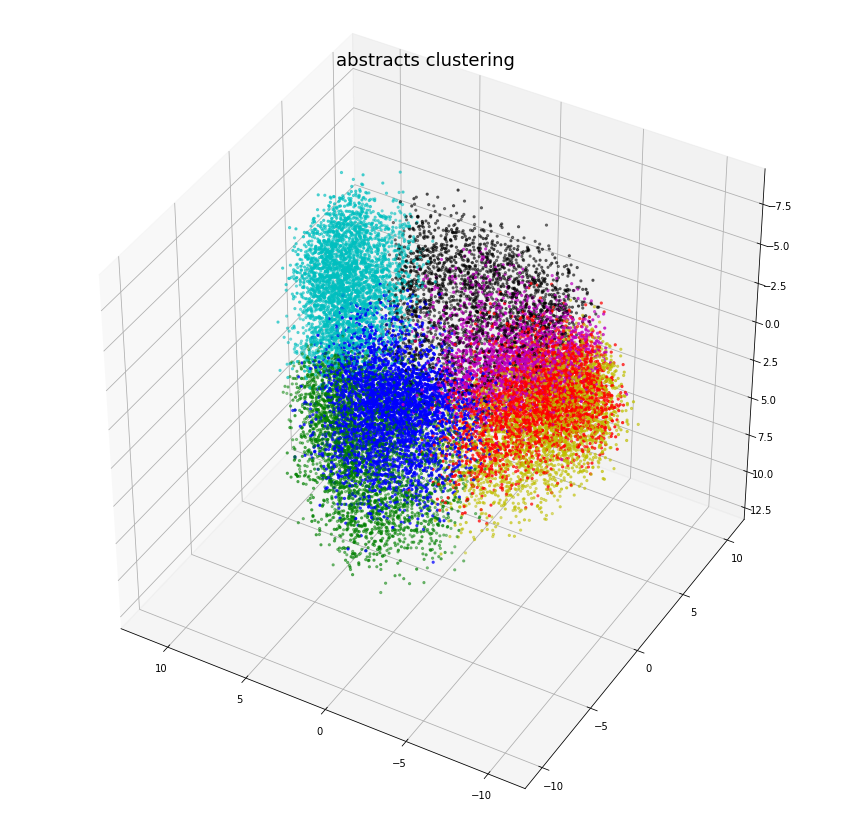

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
d = {0: 'b',
     1: 'g',
     2: 'r',
     3: 'c',
     4: 'm',
     5: 'y',
     6: 'k'}
col = [d[val] for val in clusterall.labels_]
ax.scatter(abst_pca[:,0], abst_pca[:,1], abst_pca[:,2],marker='.',c= col)
ax.set_title('abstracts clustering',fontsize = 18)
ax.view_init(-140, 60)
fig.show()

## Model Evaluation

There is no absolute way to perform evaluation on the model as it is unsupervised learning, we have no label on the data and we are not experts in the field. However, we will perform different comparisons and analysis that will qualitatively allow to assess the results. It must be noted that to perform such analysis, we are considering as reference the performed clustering of the papers, evaluating them with other tools as well.


1.   Evaluate grouped papers by SPECTER model with each other and check if the results are consistent.
2.   Compare to results yielded by other models on same clustering.
3.   Repeat similarity calculation of the model within clusters but enrich text samples.

The first intuitive way to see if the model is good is by accessing the clusters we identified. Several paper titles within the cluster are expected to "match" most relevant words inside the cluster.

In [ ]:
# Check some samples in one cluster. 
cluster_check_label = 0
sample_from_cluster = df[ df.labels == cluster_check_label ].sample(n=10)
sample_from_cluster = sample_from_cluster.reset_index()
sample_from_cluster = sample_from_cluster.rename(columns={"level_0": "df_index"})

In [ ]:
print('Cluster ', cluster_check_label, ' words: ',cluster_words_dict[cluster_check_label])
print()
print('Ten sample titles from cluster ', cluster_check_label)
for i in range(sample_from_cluster.shape[0]):
  print('Title ', i, '> ', sample_from_cluster['title'].iloc[i])


Cluster  0  words:  ['results' 'disease' 'high' 'treatment' 'analysis' 'potential' 'model'
 'clinical' 'different' 'review' 'activity' 'protein' 'cancer' 'effects'
 'studies' 'human']

Ten sample titles from cluster  0
Title  0 >  Identifying the Hot Spot Residues of the SARS-CoV-2 Main Protease Using MM-PBSA and Multiple Force Fields
Title  1 >  Identification of ligand binding sites in intrinsically disordered proteins with a differential binding score
Title  2 >  Gut Microbiota and SCFAs Play Key Roles in QingFei Yin Recipe Anti-Streptococcal Pneumonia Effects
Title  3 >  Implementation of Snow and Ice Sports Health and Sports Information Collection System Based on Internet of Things
Title  4 >  Myasthenia Gravis Masquerading as Status Asthmaticus
Title  5 >  3D Printing of Customizable Phantoms to Replace Cadaveric Models in Upper Extremity Surgical Residency Training
Title  6 >  Site-Specific Labeling of Endogenous Proteins Using CoLDR Chemistry
Title  7 >  Progress of Microfluidi

As an example, “cluster 0” words were related to treatments and covid19 effects and included [ “effects, results, clinical, studies” ]. 
Some of these titles look quite technical and somehow discuss health problems, possible secondary effects and medical techniques. Others, indeed show no relation to the topics, even to covid19.

In [ ]:
# Get 1 sample from each different cluster
labels = df.labels.unique()
different_cluster_samples = df[ df.labels == cluster_check_label ].sample(n=1)
for i in range(2, max(labels)+1):
  if i != cluster_check_label:
    different_cluster_samples = pd.concat( [different_cluster_samples, df[ df.labels == i ].sample(n=1)], axis=0)

different_cluster_samples = different_cluster_samples.reset_index()
different_cluster_samples = different_cluster_samples.rename(columns={"level_0": "df_index"})

In [ ]:
#Taken from previous homework, a trival similarity model and calculation based on compression.

def NCD(x,y):
  '''
  * Similarity metric *
  Getting the Normalized Compression Distance of two objects
  using the gzip
  input: 
           x,y - objects
  returns:
           Distance \in [0,1] where:
              0 - Identical
              1 - Completely dissimilar
  '''
  xy = x + y  # concatenates objects
  x_c = gzip.compress(bytes(x, 'utf-8'))   # x compression
  y_c= gzip.compress(bytes(y, 'utf-8'))  # y compression
  xy_c = gzip.compress(bytes(xy, 'utf-8'))  #concatenated file compression
  # Calculating 'distance'
  ncd = (len(xy_c) - min(len(x_c), len(y_c))) / max(len(x_c), len(y_c))
  return ncd

In [ ]:
# Calculate similarity with different methods within the same cluster.

specter_similarity_cluster = []
w2v_similarity_cluster = []
gzip_ncd_similarity_cluster = []

ref_abstract = different_cluster_samples['abstract'].iloc[0]
for i in range(sample_from_cluster.shape[0]):
  compare_abstract = sample_from_cluster['abstract'].iloc[i]
  specter_similarity_cluster.append( Papers_Sim(model_specter, ref_abstract, compare_abstract) ) 
  w2v_similarity_cluster.append( Spacy_Papers_Sim(spacy_model, ref_abstract, compare_abstract ) )
  gzip_ncd_similarity_cluster.append( NCD(ref_abstract, compare_abstract ) )

In [ ]:
# Calculate similarity with different methods with "distant" papers in other cluster.
specter_similarity_other_cluster = []
w2v_similarity_other_cluster = []
gzip_ncd_similarity_other_cluster = []

ref_abstract = different_cluster_samples['abstract'].iloc[0]
for i in range(different_cluster_samples.shape[0]):
  compare_abstract = different_cluster_samples['abstract'].iloc[i]
  specter_similarity_other_cluster.append( Papers_Sim(model_specter, ref_abstract, compare_abstract) ) 
  w2v_similarity_other_cluster.append( Spacy_Papers_Sim(spacy_model, ref_abstract, compare_abstract ) )
  gzip_ncd_similarity_other_cluster.append( NCD(ref_abstract, compare_abstract ) )

Standing on a particular reference paper, we now have similarity measure of that sample with respect to:
- Several other similar samples according to our model
- One sample of each of other clusters

In [ ]:
specter_similar_variance = np.var(specter_similarity_cluster)
specter_distant_variance = np.var(specter_similarity_other_cluster)
print('Variance with similar papers:                     ', specter_similar_variance)
print('Variance with "distant" papers in other clusters: ', specter_distant_variance)

Variance with similar papers:                      0.0045453710165852
Variance with "distant" papers in other clusters:  0.02955789237215553


It makes sense that the variance is higher as the samples of different clusters are more spread out. Will now present results of similarity yielded of same papers but with other models and methods: Word2Vec embedding and a trivial Normalized-Compression-Distance calculation.

In [ ]:
w2v_similar_variance = np.var(w2v_similarity_cluster)
w2v_distant_variance = np.var(w2v_similarity_other_cluster)
ncd_similar_variance = np.var(gzip_ncd_similarity_cluster)
ncd_distant_variance = np.var(gzip_ncd_similarity_other_cluster)

same_cluster = ["Yes", "No"]
ncd_var = [ncd_similar_variance, ncd_distant_variance]
specter_var = [specter_similar_variance, specter_distant_variance]
w2v_var = [w2v_similar_variance, w2v_distant_variance]
  
dict = {'Same Cluster': same_cluster, 'Specter': specter_var, 'W2V': w2v_var, 'NCD':ncd_var} 
model_variance_df = pd.DataFrame(dict)
model_variance_df 

,Same Cluster,Specter,W2V,NCD
0,Yes,0.004545,0.000079,0.000248
1,No,0.029558,0.000871,0.103545


The results are consistent when evaluated by other methods, as Word2Vec and NCD show more variance when evaluated with distant papers yielded by Specter and its clustering than when using close samples.

Finally, we will test the SPECTER model by enriching some samples of the corpus with other samples. This will make papers more similar thus bringing them closer.

In [ ]:
regular_specter_similarity_other_cluster = []
enriched_specter_similarity_other_cluster = []

# Paper abstract to be used as reference.
ref_abstract = different_cluster_samples['abstract'].iloc[0]

for i in range(different_cluster_samples.shape[0]):
  compare_abstract = different_cluster_samples['abstract'].iloc[i] #paper to be compared to
  enrich_comparable_with_ref = compare_abstract + ref_abstract #enriching paper

  regular_similarity = Papers_Sim(model_specter, ref_abstract, compare_abstract)
  regular_specter_similarity_other_cluster.append(regular_similarity)

  enriched_similarity = Papers_Sim(model_specter, ref_abstract, enrich_comparable_with_ref)
  enriched_specter_similarity_other_cluster.append(enriched_similarity)

In [ ]:
enriched_df = pd.DataFrame( list(zip(regular_specter_similarity_other_cluster, enriched_specter_similarity_other_cluster)), 
                           columns =['Regular Comparison', 'Enriched Comparison'])
enriched_df

,Regular Comparison,Enriched Comparison
0,1.000000,0.984011
1,0.638931,0.801007
2,0.532656,0.579946
3,0.540288,0.802859
4,0.590241,0.705407
5,0.484160,0.626126


We can observe that by enriching the text it will actually bring closer the papers as they will be more similar, and this is consistent with the model. It is worth noting that the only sample that does not follow this is number 0 as it is comparing the paper with itself, and by enriching it we are modifying it. Finally, as sanity check, we should observe that the variance on the distance to the samples should be reduced when these samples are enriched.

In [ ]:
print('Regular Specter Distance to different cluster samples variance:   ', np.var(regular_specter_similarity_other_cluster))
print('Specter Distance to different cluster enriched samples variance:  ', np.var(enriched_specter_similarity_other_cluster))

Regular Specter Distance to different cluster samples variance:    0.02955789237215553
Specter Distance to different cluster enriched samples variance:   0.01773475178062927
